In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pylab as plt

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
import optuna
from my_oanda.my_oanda import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C


In [5]:
start = "2020-8-1"
end = "2021-2-14"
glan = "M10"
inst = "USD_JPY"

In [6]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
)

In [7]:
def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    score =  -mybot.backtest(from_date=start, to_date=end)['total profit']
#     print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [8]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-02-20 19:01:47,869] A new study created in memory with name: no-name-98a1a640-d83a-419c-be26-dc0c3b709678
[I 2021-02-20 19:01:59,733] Trial 0 finished with value: -3360.0 and parameters: {'a': 33, 'b': 19, 'c': 8, 'd': 34, 'stop_loss': 46, 'take_profit': 43}. Best is trial 0 with value: -3360.0.
[I 2021-02-20 19:01:59,847] Trial 1 finished with value: -1730.0 and parameters: {'a': 18, 'b': 34, 'c': 19, 'd': 36, 'stop_loss': 40, 'take_profit': 41}. Best is trial 0 with value: -3360.0.
[I 2021-02-20 19:01:59,997] Trial 2 finished with value: -45610.0 and parameters: {'a': 12, 'b': 45, 'c': 47, 'd': 27, 'stop_loss': 49, 'take_profit': 6}. Best is trial 2 with value: -45610.0.
[I 2021-02-20 19:02:00,113] Trial 3 finished with value: -36670.0 and parameters: {'a': 34, 'b': 17, 'c': 46, 'd': 40, 'stop_loss': 6, 'take_profit': 41}. Best is trial 2 with value: -45610.0.
[I 2021-02-20 19:02:00,215] Trial 4 finished with value: -11530.0 and parameters: {'a': 49, 'b': 37, 'c': 31, 'd': 38

[I 2021-02-20 19:02:04,774] Trial 39 finished with value: 7320.0 and parameters: {'a': 29, 'b': 15, 'c': 40, 'd': 31, 'stop_loss': 22, 'take_profit': 26}. Best is trial 15 with value: -51480.0.
[I 2021-02-20 19:02:04,901] Trial 40 finished with value: -21470.0 and parameters: {'a': 38, 'b': 37, 'c': 37, 'd': 39, 'stop_loss': 10, 'take_profit': 30}. Best is trial 15 with value: -51480.0.
[I 2021-02-20 19:02:05,043] Trial 41 finished with value: -15430.0 and parameters: {'a': 7, 'b': 46, 'c': 44, 'd': 26, 'stop_loss': 5, 'take_profit': 39}. Best is trial 15 with value: -51480.0.
[I 2021-02-20 19:02:05,166] Trial 42 finished with value: -30120.0 and parameters: {'a': 14, 'b': 19, 'c': 47, 'd': 28, 'stop_loss': 13, 'take_profit': 35}. Best is trial 15 with value: -51480.0.
[I 2021-02-20 19:02:05,350] Trial 43 finished with value: -28840.0 and parameters: {'a': 11, 'b': 31, 'c': 42, 'd': 31, 'stop_loss': 7, 'take_profit': 43}. Best is trial 15 with value: -51480.0.
[I 2021-02-20 19:02:05,48

[I 2021-02-20 19:02:10,231] Trial 79 finished with value: -25310.0 and parameters: {'a': 6, 'b': 17, 'c': 26, 'd': 33, 'stop_loss': 33, 'take_profit': 22}. Best is trial 61 with value: -60090.0.
[I 2021-02-20 19:02:10,397] Trial 80 finished with value: -24360.0 and parameters: {'a': 9, 'b': 29, 'c': 12, 'd': 31, 'stop_loss': 36, 'take_profit': 25}. Best is trial 61 with value: -60090.0.
[I 2021-02-20 19:02:10,526] Trial 81 finished with value: -42730.0 and parameters: {'a': 12, 'b': 20, 'c': 18, 'd': 34, 'stop_loss': 34, 'take_profit': 24}. Best is trial 61 with value: -60090.0.
[I 2021-02-20 19:02:10,654] Trial 82 finished with value: -46020.0 and parameters: {'a': 13, 'b': 22, 'c': 21, 'd': 34, 'stop_loss': 30, 'take_profit': 23}. Best is trial 61 with value: -60090.0.
[I 2021-02-20 19:02:10,791] Trial 83 finished with value: -34420.0 and parameters: {'a': 11, 'b': 19, 'c': 16, 'd': 36, 'stop_loss': 31, 'take_profit': 19}. Best is trial 61 with value: -60090.0.
[I 2021-02-20 19:02:10

[I 2021-02-20 19:02:16,182] Trial 119 finished with value: -39300.0 and parameters: {'a': 7, 'b': 25, 'c': 5, 'd': 33, 'stop_loss': 10, 'take_profit': 48}. Best is trial 102 with value: -76650.0.
[I 2021-02-20 19:02:16,331] Trial 120 finished with value: -67980.0 and parameters: {'a': 5, 'b': 24, 'c': 8, 'd': 34, 'stop_loss': 6, 'take_profit': 47}. Best is trial 102 with value: -76650.0.
[I 2021-02-20 19:02:16,520] Trial 121 finished with value: -67980.0 and parameters: {'a': 5, 'b': 24, 'c': 8, 'd': 34, 'stop_loss': 6, 'take_profit': 47}. Best is trial 102 with value: -76650.0.
[I 2021-02-20 19:02:16,670] Trial 122 finished with value: -67980.0 and parameters: {'a': 5, 'b': 24, 'c': 8, 'd': 34, 'stop_loss': 6, 'take_profit': 47}. Best is trial 102 with value: -76650.0.
[I 2021-02-20 19:02:16,817] Trial 123 finished with value: -67980.0 and parameters: {'a': 5, 'b': 24, 'c': 8, 'd': 34, 'stop_loss': 6, 'take_profit': 47}. Best is trial 102 with value: -76650.0.
[I 2021-02-20 19:02:16,9

[I 2021-02-20 19:02:22,418] Trial 159 finished with value: -53080.0 and parameters: {'a': 8, 'b': 21, 'c': 6, 'd': 37, 'stop_loss': 7, 'take_profit': 41}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:22,566] Trial 160 finished with value: -55230.0 and parameters: {'a': 5, 'b': 23, 'c': 10, 'd': 36, 'stop_loss': 8, 'take_profit': 40}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:22,720] Trial 161 finished with value: -72190.0 and parameters: {'a': 5, 'b': 21, 'c': 8, 'd': 35, 'stop_loss': 5, 'take_profit': 44}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:22,913] Trial 162 finished with value: -68720.0 and parameters: {'a': 5, 'b': 20, 'c': 7, 'd': 35, 'stop_loss': 5, 'take_profit': 43}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:23,064] Trial 163 finished with value: -57110.0 and parameters: {'a': 7, 'b': 18, 'c': 6, 'd': 35, 'stop_loss': 5, 'take_profit': 43}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:23,2

[I 2021-02-20 19:02:28,680] Trial 199 finished with value: -56900.0 and parameters: {'a': 7, 'b': 23, 'c': 5, 'd': 38, 'stop_loss': 7, 'take_profit': 39}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:28,830] Trial 200 finished with value: -72520.0 and parameters: {'a': 5, 'b': 23, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 46}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:28,981] Trial 201 finished with value: -72520.0 and parameters: {'a': 5, 'b': 23, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 46}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:29,130] Trial 202 finished with value: -68120.0 and parameters: {'a': 5, 'b': 22, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 46}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:29,315] Trial 203 finished with value: -56910.0 and parameters: {'a': 7, 'b': 23, 'c': 10, 'd': 39, 'stop_loss': 7, 'take_profit': 46}. Best is trial 148 with value: -78170.0.
[I 2021-02-20 19:02:29,4

[I 2021-02-20 19:02:34,884] Trial 239 finished with value: -71190.0 and parameters: {'a': 6, 'b': 22, 'c': 6, 'd': 38, 'stop_loss': 5, 'take_profit': 48}. Best is trial 232 with value: -78600.0.
[I 2021-02-20 19:02:35,071] Trial 240 finished with value: -74370.0 and parameters: {'a': 7, 'b': 24, 'c': 7, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 232 with value: -78600.0.
[I 2021-02-20 19:02:35,220] Trial 241 finished with value: -65010.0 and parameters: {'a': 7, 'b': 24, 'c': 7, 'd': 36, 'stop_loss': 6, 'take_profit': 47}. Best is trial 232 with value: -78600.0.
[I 2021-02-20 19:02:35,373] Trial 242 finished with value: -74980.0 and parameters: {'a': 6, 'b': 23, 'c': 7, 'd': 39, 'stop_loss': 5, 'take_profit': 47}. Best is trial 232 with value: -78600.0.
[I 2021-02-20 19:02:35,525] Trial 243 finished with value: -71880.0 and parameters: {'a': 7, 'b': 24, 'c': 5, 'd': 37, 'stop_loss': 5, 'take_profit': 49}. Best is trial 232 with value: -78600.0.
[I 2021-02-20 19:02:35,71

[I 2021-02-20 19:02:41,239] Trial 279 finished with value: -72140.0 and parameters: {'a': 11, 'b': 26, 'c': 12, 'd': 40, 'stop_loss': 5, 'take_profit': 48}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:41,388] Trial 280 finished with value: -55460.0 and parameters: {'a': 9, 'b': 26, 'c': 12, 'd': 40, 'stop_loss': 7, 'take_profit': 46}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:41,580] Trial 281 finished with value: -76090.0 and parameters: {'a': 10, 'b': 27, 'c': 11, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:41,734] Trial 282 finished with value: -70450.0 and parameters: {'a': 11, 'b': 27, 'c': 11, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:41,887] Trial 283 finished with value: -70330.0 and parameters: {'a': 11, 'b': 27, 'c': 11, 'd': 40, 'stop_loss': 5, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19

[I 2021-02-20 19:02:47,586] Trial 319 finished with value: -62260.0 and parameters: {'a': 8, 'b': 28, 'c': 6, 'd': 40, 'stop_loss': 6, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:47,734] Trial 320 finished with value: -64870.0 and parameters: {'a': 10, 'b': 23, 'c': 5, 'd': 38, 'stop_loss': 7, 'take_profit': 50}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:47,873] Trial 321 finished with value: -52430.0 and parameters: {'a': 9, 'b': 26, 'c': 8, 'd': 29, 'stop_loss': 10, 'take_profit': 48}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:48,044] Trial 322 finished with value: -26960.0 and parameters: {'a': 26, 'b': 24, 'c': 6, 'd': 37, 'stop_loss': 8, 'take_profit': 47}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:48,197] Trial 323 finished with value: -75350.0 and parameters: {'a': 8, 'b': 23, 'c': 9, 'd': 39, 'stop_loss': 5, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:48

[I 2021-02-20 19:02:53,912] Trial 359 finished with value: -49590.0 and parameters: {'a': 7, 'b': 24, 'c': 8, 'd': 37, 'stop_loss': 7, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:54,063] Trial 360 finished with value: -62510.0 and parameters: {'a': 13, 'b': 25, 'c': 11, 'd': 38, 'stop_loss': 5, 'take_profit': 48}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:54,214] Trial 361 finished with value: -76640.0 and parameters: {'a': 10, 'b': 23, 'c': 9, 'd': 39, 'stop_loss': 6, 'take_profit': 46}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:54,369] Trial 362 finished with value: -61740.0 and parameters: {'a': 9, 'b': 22, 'c': 9, 'd': 40, 'stop_loss': 5, 'take_profit': 45}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:54,557] Trial 363 finished with value: -47410.0 and parameters: {'a': 8, 'b': 23, 'c': 10, 'd': 36, 'stop_loss': 7, 'take_profit': 46}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:02:5

[I 2021-02-20 19:03:00,315] Trial 399 finished with value: -60120.0 and parameters: {'a': 5, 'b': 26, 'c': 11, 'd': 38, 'stop_loss': 6, 'take_profit': 50}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:00,472] Trial 400 finished with value: -63410.0 and parameters: {'a': 7, 'b': 24, 'c': 13, 'd': 37, 'stop_loss': 5, 'take_profit': 14}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:00,620] Trial 401 finished with value: -43050.0 and parameters: {'a': 12, 'b': 25, 'c': 10, 'd': 38, 'stop_loss': 7, 'take_profit': 48}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:00,778] Trial 402 finished with value: -74210.0 and parameters: {'a': 6, 'b': 22, 'c': 11, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:00,932] Trial 403 finished with value: -66010.0 and parameters: {'a': 7, 'b': 24, 'c': 10, 'd': 37, 'stop_loss': 6, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03

[I 2021-02-20 19:03:06,692] Trial 439 finished with value: -43790.0 and parameters: {'a': 9, 'b': 25, 'c': 8, 'd': 35, 'stop_loss': 13, 'take_profit': 31}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:06,880] Trial 440 finished with value: -56350.0 and parameters: {'a': 7, 'b': 24, 'c': 5, 'd': 40, 'stop_loss': 8, 'take_profit': 46}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:07,015] Trial 441 finished with value: -37440.0 and parameters: {'a': 29, 'b': 23, 'c': 7, 'd': 39, 'stop_loss': 7, 'take_profit': 48}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:07,169] Trial 442 finished with value: -79000.0 and parameters: {'a': 10, 'b': 27, 'c': 7, 'd': 38, 'stop_loss': 5, 'take_profit': 49}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:07,322] Trial 443 finished with value: -61980.0 and parameters: {'a': 6, 'b': 26, 'c': 6, 'd': 38, 'stop_loss': 6, 'take_profit': 47}. Best is trial 271 with value: -82630.0.
[I 2021-02-20 19:03:07

[I 2021-02-20 19:03:13,059] Trial 479 finished with value: -71780.0 and parameters: {'a': 7, 'b': 24, 'c': 5, 'd': 37, 'stop_loss': 5, 'take_profit': 48}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:13,212] Trial 480 finished with value: -53120.0 and parameters: {'a': 5, 'b': 25, 'c': 6, 'd': 38, 'stop_loss': 7, 'take_profit': 50}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:13,402] Trial 481 finished with value: -60400.0 and parameters: {'a': 6, 'b': 24, 'c': 5, 'd': 39, 'stop_loss': 8, 'take_profit': 49}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:13,554] Trial 482 finished with value: -67700.0 and parameters: {'a': 9, 'b': 25, 'c': 6, 'd': 37, 'stop_loss': 6, 'take_profit': 48}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:13,709] Trial 483 finished with value: -80140.0 and parameters: {'a': 7, 'b': 24, 'c': 5, 'd': 38, 'stop_loss': 5, 'take_profit': 50}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:13,86

[I 2021-02-20 19:03:19,522] Trial 519 finished with value: -81760.0 and parameters: {'a': 7, 'b': 24, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 49}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:19,679] Trial 520 finished with value: -79830.0 and parameters: {'a': 8, 'b': 24, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 50}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:19,836] Trial 521 finished with value: -57180.0 and parameters: {'a': 9, 'b': 26, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 37}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:20,032] Trial 522 finished with value: -71710.0 and parameters: {'a': 8, 'b': 25, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 50}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:20,188] Trial 523 finished with value: -59390.0 and parameters: {'a': 9, 'b': 25, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 50}. Best is trial 473 with value: -82860.0.
[I 2021-02-20 19:03:20,34

[I 2021-02-20 19:03:26,042] Trial 559 finished with value: -41600.0 and parameters: {'a': 11, 'b': 26, 'c': 7, 'd': 38, 'stop_loss': 24, 'take_profit': 46}. Best is trial 529 with value: -85530.0.
[I 2021-02-20 19:03:26,197] Trial 560 finished with value: -75790.0 and parameters: {'a': 10, 'b': 25, 'c': 6, 'd': 40, 'stop_loss': 6, 'take_profit': 49}. Best is trial 529 with value: -85530.0.
[I 2021-02-20 19:03:26,354] Trial 561 finished with value: -59190.0 and parameters: {'a': 9, 'b': 25, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 48}. Best is trial 529 with value: -85530.0.
[I 2021-02-20 19:03:26,507] Trial 562 finished with value: -36930.0 and parameters: {'a': 9, 'b': 28, 'c': 20, 'd': 38, 'stop_loss': 7, 'take_profit': 50}. Best is trial 529 with value: -85530.0.
[I 2021-02-20 19:03:26,697] Trial 563 finished with value: -64890.0 and parameters: {'a': 12, 'b': 24, 'c': 7, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 529 with value: -85530.0.
[I 2021-02-20 19:03:

[I 2021-02-20 19:03:32,660] Trial 599 finished with value: -68650.0 and parameters: {'a': 10, 'b': 25, 'c': 10, 'd': 40, 'stop_loss': 6, 'take_profit': 26}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:32,814] Trial 600 finished with value: -61940.0 and parameters: {'a': 10, 'b': 26, 'c': 10, 'd': 39, 'stop_loss': 7, 'take_profit': 34}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:32,972] Trial 601 finished with value: -71920.0 and parameters: {'a': 12, 'b': 28, 'c': 9, 'd': 39, 'stop_loss': 5, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:33,129] Trial 602 finished with value: -62390.0 and parameters: {'a': 11, 'b': 25, 'c': 9, 'd': 40, 'stop_loss': 6, 'take_profit': 29}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:33,289] Trial 603 finished with value: -59300.0 and parameters: {'a': 9, 'b': 27, 'c': 10, 'd': 39, 'stop_loss': 5, 'take_profit': 25}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:0

[I 2021-02-20 19:03:39,147] Trial 639 finished with value: -64400.0 and parameters: {'a': 9, 'b': 25, 'c': 7, 'd': 40, 'stop_loss': 6, 'take_profit': 33}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:39,343] Trial 640 finished with value: -59400.0 and parameters: {'a': 11, 'b': 25, 'c': 5, 'd': 39, 'stop_loss': 6, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:39,499] Trial 641 finished with value: -61210.0 and parameters: {'a': 10, 'b': 27, 'c': 6, 'd': 40, 'stop_loss': 7, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:39,665] Trial 642 finished with value: -70170.0 and parameters: {'a': 9, 'b': 24, 'c': 7, 'd': 39, 'stop_loss': 5, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:39,822] Trial 643 finished with value: -60910.0 and parameters: {'a': 12, 'b': 25, 'c': 8, 'd': 39, 'stop_loss': 6, 'take_profit': 36}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:39

[I 2021-02-20 19:03:45,786] Trial 679 finished with value: -77980.0 and parameters: {'a': 10, 'b': 25, 'c': 8, 'd': 40, 'stop_loss': 5, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:45,945] Trial 680 finished with value: -62080.0 and parameters: {'a': 9, 'b': 26, 'c': 6, 'd': 38, 'stop_loss': 5, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:46,138] Trial 681 finished with value: -49660.0 and parameters: {'a': 13, 'b': 24, 'c': 9, 'd': 39, 'stop_loss': 7, 'take_profit': 35}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:46,299] Trial 682 finished with value: -64690.0 and parameters: {'a': 11, 'b': 28, 'c': 6, 'd': 40, 'stop_loss': 5, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:46,452] Trial 683 finished with value: -47580.0 and parameters: {'a': 9, 'b': 25, 'c': 5, 'd': 39, 'stop_loss': 9, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:46

[I 2021-02-20 19:03:52,311] Trial 719 finished with value: -73620.0 and parameters: {'a': 10, 'b': 25, 'c': 9, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:52,472] Trial 720 finished with value: -74980.0 and parameters: {'a': 11, 'b': 24, 'c': 9, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:52,629] Trial 721 finished with value: -66870.0 and parameters: {'a': 9, 'b': 22, 'c': 8, 'd': 38, 'stop_loss': 6, 'take_profit': 39}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:52,828] Trial 722 finished with value: -78090.0 and parameters: {'a': 12, 'b': 26, 'c': 11, 'd': 39, 'stop_loss': 5, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:52,985] Trial 723 finished with value: -72920.0 and parameters: {'a': 10, 'b': 23, 'c': 12, 'd': 40, 'stop_loss': 6, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03

[I 2021-02-20 19:03:58,944] Trial 759 finished with value: -43740.0 and parameters: {'a': 12, 'b': 24, 'c': 14, 'd': 38, 'stop_loss': 7, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:59,102] Trial 760 finished with value: -72950.0 and parameters: {'a': 10, 'b': 22, 'c': 12, 'd': 39, 'stop_loss': 6, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:59,265] Trial 761 finished with value: -76730.0 and parameters: {'a': 8, 'b': 24, 'c': 15, 'd': 39, 'stop_loss': 5, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:59,422] Trial 762 finished with value: -67190.0 and parameters: {'a': 11, 'b': 24, 'c': 14, 'd': 38, 'stop_loss': 6, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:03:59,612] Trial 763 finished with value: -33770.0 and parameters: {'a': 9, 'b': 23, 'c': 15, 'd': 38, 'stop_loss': 22, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19

[I 2021-02-20 19:04:05,658] Trial 799 finished with value: -53250.0 and parameters: {'a': 34, 'b': 22, 'c': 7, 'd': 40, 'stop_loss': 6, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:05,869] Trial 800 finished with value: -67150.0 and parameters: {'a': 9, 'b': 23, 'c': 8, 'd': 39, 'stop_loss': 5, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:06,029] Trial 801 finished with value: -44640.0 and parameters: {'a': 11, 'b': 27, 'c': 13, 'd': 38, 'stop_loss': 7, 'take_profit': 45}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:06,200] Trial 802 finished with value: -67800.0 and parameters: {'a': 8, 'b': 25, 'c': 7, 'd': 40, 'stop_loss': 5, 'take_profit': 43}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:06,367] Trial 803 finished with value: -78870.0 and parameters: {'a': 10, 'b': 24, 'c': 11, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:

[I 2021-02-20 19:04:12,704] Trial 839 finished with value: -48870.0 and parameters: {'a': 13, 'b': 26, 'c': 8, 'd': 40, 'stop_loss': 31, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:12,885] Trial 840 finished with value: -75880.0 and parameters: {'a': 10, 'b': 25, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:13,089] Trial 841 finished with value: -53430.0 and parameters: {'a': 9, 'b': 24, 'c': 14, 'd': 39, 'stop_loss': 7, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:13,265] Trial 842 finished with value: -67960.0 and parameters: {'a': 11, 'b': 25, 'c': 17, 'd': 40, 'stop_loss': 5, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:13,442] Trial 843 finished with value: -68540.0 and parameters: {'a': 9, 'b': 22, 'c': 8, 'd': 37, 'stop_loss': 6, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04

[I 2021-02-20 19:04:19,692] Trial 879 finished with value: -62990.0 and parameters: {'a': 11, 'b': 23, 'c': 31, 'd': 38, 'stop_loss': 5, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:19,863] Trial 880 finished with value: -55360.0 and parameters: {'a': 9, 'b': 22, 'c': 9, 'd': 39, 'stop_loss': 7, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:20,064] Trial 881 finished with value: -45650.0 and parameters: {'a': 10, 'b': 25, 'c': 12, 'd': 38, 'stop_loss': 21, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:20,235] Trial 882 finished with value: -65460.0 and parameters: {'a': 13, 'b': 24, 'c': 5, 'd': 39, 'stop_loss': 5, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:20,404] Trial 883 finished with value: -67870.0 and parameters: {'a': 8, 'b': 23, 'c': 12, 'd': 37, 'stop_loss': 6, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:0

[I 2021-02-20 19:04:26,606] Trial 919 finished with value: -59210.0 and parameters: {'a': 13, 'b': 23, 'c': 10, 'd': 38, 'stop_loss': 5, 'take_profit': 46}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:26,760] Trial 920 finished with value: -49180.0 and parameters: {'a': 10, 'b': 25, 'c': 6, 'd': 37, 'stop_loss': 27, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:26,915] Trial 921 finished with value: -63560.0 and parameters: {'a': 12, 'b': 24, 'c': 12, 'd': 39, 'stop_loss': 11, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:27,115] Trial 922 finished with value: -52110.0 and parameters: {'a': 9, 'b': 27, 'c': 9, 'd': 39, 'stop_loss': 7, 'take_profit': 49}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:27,283] Trial 923 finished with value: -72880.0 and parameters: {'a': 11, 'b': 23, 'c': 7, 'd': 40, 'stop_loss': 5, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:

[I 2021-02-20 19:04:33,500] Trial 959 finished with value: -66650.0 and parameters: {'a': 10, 'b': 24, 'c': 9, 'd': 39, 'stop_loss': 9, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:33,664] Trial 960 finished with value: -64500.0 and parameters: {'a': 9, 'b': 25, 'c': 7, 'd': 38, 'stop_loss': 5, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:33,825] Trial 961 finished with value: -60950.0 and parameters: {'a': 11, 'b': 26, 'c': 11, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:33,992] Trial 962 finished with value: -72530.0 and parameters: {'a': 8, 'b': 23, 'c': 10, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04:34,189] Trial 963 finished with value: -45840.0 and parameters: {'a': 11, 'b': 24, 'c': 15, 'd': 39, 'stop_loss': 7, 'take_profit': 48}. Best is trial 568 with value: -86510.0.
[I 2021-02-20 19:04

[I 2021-02-20 19:04:40,285] Trial 999 finished with value: -51450.0 and parameters: {'a': 8, 'b': 27, 'c': 5, 'd': 38, 'stop_loss': 7, 'take_profit': 49}. Best is trial 568 with value: -86510.0.


In [9]:
params=study.best_trial.params

In [10]:
params

{'a': 10, 'b': 24, 'c': 8, 'd': 39, 'stop_loss': 5, 'take_profit': 48}

In [11]:
mybot.set_param(params['a'], params['b'], params['c'], params['d'], params['stop_loss'], params['take_profit'])

total profit        86510.000
total trades         2049.000
win rate               46.510
profit factor           1.138
maximum drawdown    14540.000
recovery factor         5.950
riskreward ratio        1.503
sharpe ratio            0.055
average return         37.110
stop loss            1255.000
take profit             1.000
dtype: float64


total profit        86510.000
total trades         2049.000
win rate               46.510
profit factor           1.138
maximum drawdown    14540.000
recovery factor         5.950
riskreward ratio        1.503
sharpe ratio            0.055
average return         37.110
stop loss            1255.000
take profit             1.000
dtype: float64

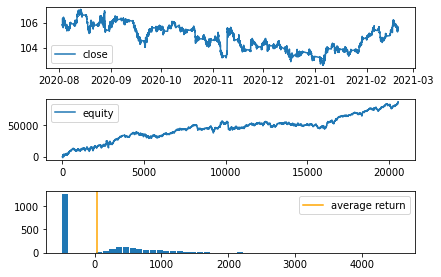

In [12]:
mybot.backtest(from_date=start, to_date=end, filename="backtest.png", show=True)

In [13]:
#total profit        14490.000